In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [3]:
def center(x):
    x = np.array(x)
    mean = x.mean(axis=1, keepdims=True)
    return x - mean

In [4]:
x = center(x)
x

array([[-1.,  0.,  1.],
       [ 2.,  1., -3.]])

In [5]:
def whitening(x):
    cov = np.cov(x)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    x_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, x)))
    return x_whiten


In [6]:
x = whitening(x)
x

array([[-1.06083349,  0.92535248,  0.13548101],
       [ 0.45603251,  0.69069249, -1.146725  ]])

In [7]:
def g(x):
    return np.tanh(x)
def g_der(x):
    return 1 - g(x) * g(x)

In [8]:
def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())
    return w_new

In [18]:
def ica(X, iterations, tolerance=1e-5):
    X = center(X)
    X = whitening(X)  
    components_nr = X.shape[0]
    W = np.zeros((components_nr, components_nr), dtype=X.dtype)
    for i in range(components_nr):
        w = np.random.rand(components_nr)
        for j in range(iterations):
            w_new = calculate_new_w(w, X)
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new
            if distance < tolerance:
                break    
        W[i, :] = w
        print(W)
    S = np.dot(W, X)
    return S

In [10]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure(figsize = (10,8))

    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")

    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")

    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show()

In [11]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        
        max_val = np.max(mixtures[i])
        
        if max_val > 1 or np.min(mixtures[i]) < 1:
            
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
            
    X = np.c_[[mix for mix in mixtures]]
    
    if apply_noise:
        
        X += 0.02 * np.random.normal(size=X.shape)
        
    return X

In [12]:
t = np.linspace(0,4,100)
s1 = (np.sin(t))*(np.sin(t))+np.cos(t)
s2 = np.sin(3*t + np.pi/2)
s3 = signal.sawtooth(2 * np.pi * t)

[[ 0.26651752  0.95367969 -0.13951148]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 0.26651752  0.95367969 -0.13951148]
 [ 0.2510135  -0.20808529 -0.94291325]
 [ 0.          0.          0.        ]]
[[ 0.26651752  0.95367969 -0.13951148]
 [ 0.2510135  -0.20808529 -0.94291325]
 [-0.92673036  0.2159873  -0.29393406]]


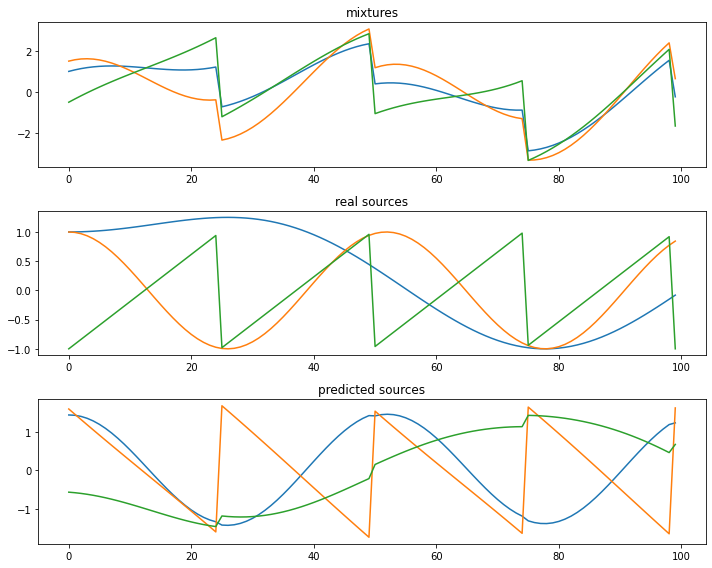

In [26]:
X = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1], [1, 0.5, 2]]))
X = np.dot(X, A.T)
X = X.T
S = ica(X, iterations=1000)
#actual = mix_sources([s1,s2,s3])
plot_mixture_sources_predictions(X, [s1, s2, s3], S)

[[-0.72779187 -0.68579807]
 [ 0.          0.        ]]
[[-0.72779187 -0.68579807]
 [ 0.68579783 -0.7277916 ]]


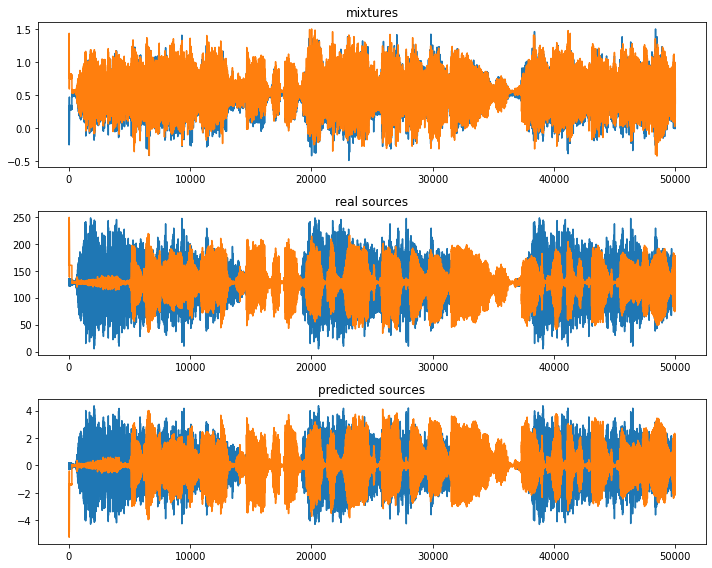

In [14]:
sampling_rate, mix1 = wavfile.read('mix1.wav')
sampling_rate, mix2 = wavfile.read('mix2.wav')
sampling_rate, source1 = wavfile.read('source1.wav')
sampling_rate, source2 = wavfile.read('source2.wav')
actual = mix_sources([source1, source2], False)
X = mix_sources([mix1, mix2])
S = ica(X, iterations=1000)

plot_mixture_sources_predictions(X, [source1, source2], S)

wavfile.write('out1.wav', sampling_rate, S[0])
wavfile.write('out2.wav', sampling_rate, S[1])

In [15]:
X.shape

(2, 50000)